# Project 1 NYC Subway Network
## Step 1 - Build the Subway Files

This phase of Project 1 constructs the NYC subway graph from the GTFS data files provided by the Metropolitan Transit Authority in the latest available dataset (as of Dec 2021).  The GTFS data files are text files with comma separated fields per row.  However, figuring out the nodes and edges is complicated by  domain specific issues because the purpose of the GTFS data files is not to build graphs but to support scheduling and operations.

## Stops

We begin by defining the nodes which represent subway stations.  This data is stored in the file `stops.txt`.   We load the data and inspect the first 5 rows.

In [117]:
# Import the basic libraries

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [118]:
data_dir = "google_transit/"

stops_file = data_dir + "stops.txt"
stops_df = pd.read_csv(stops_file)
all_stops = stops_df[["stop_id", "stop_name", "stop_lat", "stop_lon", "location_type", "parent_station"]]
all_stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1,NaN
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,0,101
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,0,101
3,103,238 St,40.884667,-73.900870,1,NaN
4,103N,238 St,40.884667,-73.900870,0,103


In the above `stops` dataset, each stop is listed 3 times as a `parent` and two `child` stops. 
Using stops `101`, `101N`, `101S` as a related example, we see that the parent stop `101` is identified by the field value `location_type`=`1` while `101N` (the northbound platform of the stop) and `101S` (the southbound platform of the stop) have `location_type` = `0` and use the field `parent_station` as a foreign key back to the `stop_id` of the parent stop `101` through self-join.   However, we'll need to retain the child stops `101N` and `101S` as the edges of our graph are defined in terms of child stops.   For simplicity, we select only essential columns in a dataframe `all_stops`.

## Routes

The `routes.txt` contains the names of the routes.  It is a reference file that defines the lines of services.  For example, A, B, C, 1, 2, 3, 4, 6, 7, etc.   Each route has several useful fields which we load into a dataframe:

*   `route_id` - integer identifier of the line - this is the primary key
*   `route_long_name` - describes the route's name is not unique.  E.g. 5 and 5X are both called Lexington Avenue Express.
*   `route_color` - the hex code color assigned to the line's livery on the map, subway cars and stations.  For example, $\color{#EE352E}{\text{Routes 1, 2, 3 use EE352E}}$.   Route colors are often grouped together.   Route colors may be viewed as edge attributes.


In [119]:
routes_file = data_dir + "routes.txt"
routes_df = pd.read_csv(routes_file)
all_routes = routes_df[["route_id", "route_long_name", "route_color"]]
all_routes.head()

,route_id,route_long_name,route_color
0,1,Broadway - 7 Avenue Local,EE352E
1,2,7 Avenue Express,EE352E
2,3,7 Avenue Express,EE352E
3,4,Lexington Avenue Express,00933C
4,5,Lexington Avenue Express,00933C


# Calendar

We load the list of available services.   A service associates a schedule of availability of multiple subway lines by day of week and holidays.   We are only going to use weekday services as an object to filter the set of trips as there are thousands of trips for each line with repetitive description of edges.

In [120]:
calendar_file = data_dir + "calendar.txt"
calendar_df = pd.read_csv(calendar_file)
all_calendar = calendar_df[["service_id", "start_date", "end_date"]]
all_calendar[ all_calendar["service_id"].str.contains("Weekday") ].head()

,service_id,start_date,end_date
23,AFA21GEN-1091-Weekday-00,20211220,20220624
24,AFA21GEN-2097-Weekday-00,20211220,20220624
25,AFA21GEN-3087-Weekday-00,20211220,20220624
26,AFA21GEN-4099-Weekday-00,20211220,20220624
27,AFA21GEN-5108-Weekday-00,20211220,20220624


# Trips

The `trips.txt` file joins three object types:  routes, services and trips.   Trips are the instances of services associated with a route containing a direction of travel (outbound or inbound).   The direction of travel is immaterial to our graph and we treat both directions as equivalent.   

*   `route_id` is a foreign key to the same column in `routes.txt`
*   `service_id` is a foreign key to the same column in `calendar.txt`

The `trip_id` is unique to the file and is in a one-to-many relationship with the `route_id` and `service_id` as it specifies the time of day when the trip is scheduled to begin its operation and the direction.

In [121]:
trips_file = data_dir + "trips.txt"
trips_df = pd.read_csv(trips_file)
all_trips = trips_df[["route_id", "service_id", "trip_id", "direction_id"]]

all_trips[ all_trips["service_id"].str.contains("Weekday") ].head()

,route_id,service_id,trip_id,direction_id
584,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_000650_1..S03R,1
585,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_002550_1..S03R,1
586,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_004550_1..S03R,1
587,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_006550_1..S03R,1
588,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_007450_1..N03R,0


# Stop Times

The file `stop_times.txt` contains the list of stops along with a sequence number of each trip listed in the trips file.
The essential information of each trip is the scheduled ordered sequence of stops.  Consecutive stops within an ordered sequence of the trip define the directed edges of a digraph.  Since we are interested in the undirected network, we will ignore the directionality of the edges when scanning the trips file.

In [122]:
stop_times_file = data_dir + "stop_times.txt"
stop_times_df = pd.read_csv(stop_times_file)
all_stop_times = stop_times_df[["trip_id", "stop_id", "stop_sequence" ]]

all_stop_times[ all_stop_times["trip_id"].str.contains("Weekday") ].head( )

,trip_id,stop_id,stop_sequence
22192,AFA21GEN-1091-Weekday-00_000650_1..S03R,101S,1
22193,AFA21GEN-1091-Weekday-00_000650_1..S03R,103S,2
22194,AFA21GEN-1091-Weekday-00_000650_1..S03R,104S,3
22195,AFA21GEN-1091-Weekday-00_000650_1..S03R,106S,4
22196,AFA21GEN-1091-Weekday-00_000650_1..S03R,107S,5


A unique key of  the `all_stop_times` dataframe are the two columns `trip_id`, `stop_sequence`.  We exploit this fact to build the edge list below.

## Step 2.  Constructing the Subway Network Graphs

To construct the network, we need to form equivalence classes of several GTFS object types.
We choose only one representative of multiple members of an equivalence class of object types with 2 strategies.

*   For nodes, we'll use only the parent node in our network.  

*   The edge information has even more members in the equivalence class.   For each two adjacent stops (nodes) in our graph,  multiple routes, multiple services and multiple trips may all include the two stops.   In other words, each directed edge could be listed dozens of times within the `all_stop_times` dataframe.
     +  In any edge, the order of nodes must be lexicographically increasing.   We will represent each edge as an ordered pair of parent stops.  For example, stops `101S` and `103S` are consecutive stops for trip `AFA21GEN-1091-Weekday-00_000650_1..S03R`.   
The corresponding edge is the pair `(101, 103)`.
     +  We will maintain a dictionary of the edges.   If an edge has already been created while parsing `all_stop_times`, we don't create a duplicate edge.



In [123]:
len(all_stops[all_stops["location_type"] == 1 ].stop_id.unique())

499

To construct the edge list, we first join the parent `stop_id` to each row of the stop times dataframe.
Next, we assign the previous sequence number to each stop along a trip.  This value is saved in a column called `prior_stop_sequence`.  The original `stop_sequence` always begins at 1, so the `prior_stop_sequence` = 0 for the initial stop of the trip.
Lastly, we make a deep copy of the joined data frame in order to get the parent station of the current stop and the prior stop in the same row. 

In [124]:
res_stop_times = pd.merge( all_stop_times, all_stops , on = ['stop_id'] )

In [125]:
res_stops_times_trips = pd.merge( res_stop_times, all_trips, on = ['trip_id' ] )
res_x = res_stops_times_trips[["route_id", "trip_id", "stop_sequence", "parent_station"]]
res_prior_x = res_x.copy()

res_x['prior_stop_sequence'] = res_x['stop_sequence'] - 1
res_x

,route_id,trip_id,stop_sequence,parent_station,prior_stop_sequence
0,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,1,101,0
1,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,2,103,1
2,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,3,104,2
3,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,4,106,3
4,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,5,107,4
...,...,...,...,...,...
542113,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,9,S27,8
542114,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,10,S28,9
542115,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,11,S29,10
542116,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,12,S30,11


It is easier to rename some columns of the dataframe representing the prior stop of each trip before doing the join rather than accept the default column renaming by pandas.

In [126]:
res_prior_x.rename(columns = {'parent_station' : 'prior_station' , 
                              'stop_sequence' : 'prior_stop_sequence' ,
                              'route_id' : 'prior_route_id'
                             }, inplace = True)
res_prior_x = res_prior_x[['trip_id', 'prior_stop_sequence', 'prior_station']]

In [127]:
res_edges = pd.merge(res_x, res_prior_x, on = ['trip_id', 'prior_stop_sequence'] )
res_edges.head()

,route_id,trip_id,stop_sequence,parent_station,prior_stop_sequence,prior_station
0,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,2,103,1,101
1,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,3,104,2,103
2,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,4,106,3,104
3,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,5,107,4,106
4,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,6,108,5,107


The dataframe `res_edges` contains multiple instances of directed edges.  The multiplicity arises from the multiple trips for the same same-pair.  Moreover, we are interested in undirected edges, so we use lexicographic sort on the parent station names to ensure each edge only appears once.

In the code below, we construct derived columns `parent_a` and `parent_b` to always means either the parent station or the prior station in which `parent_a` is always lexicographically before `parent_b`.  This ensures that all edges are represented in the unlikely chance that some trips go from station X to station Y but not vice versa.  The unique set of pairs of (`parent_a`, `parent_b`) stop_ids represent all undirected edges in the NYC Subway network.

In [128]:
sel_res_edges = res_edges[["parent_station", "prior_station", "route_id"]].copy()

sel_res_edges['parent_a'] = np.where( sel_res_edges['parent_station'] < sel_res_edges['prior_station'], 
                                         sel_res_edges['parent_station'] ,
                                         sel_res_edges['prior_station'] )

sel_res_edges['parent_b'] = np.where( sel_res_edges['parent_station'] > sel_res_edges['prior_station'], 
                                         sel_res_edges['parent_station'] ,
                                         sel_res_edges['prior_station'] )

no_dups_res_edges = sel_res_edges[['parent_a', 'parent_b']].drop_duplicates(keep = 'last')

Besides undirected edges, we may need to know the name of the route joining each edge.  When a pair of nodes have multiple routes connecting them, the same unidirected edge appears multiple times.  This is stored in the dataframe `no_dups_route_edges`.   The route_id becomes an edge attribute, and the resulting graph becomes a multigraph.

In [129]:
no_dups_route_edges = sel_res_edges[['parent_a', 'parent_b', 'route_id']].drop_duplicates(keep = 'last')
no_dups_route_edges

,parent_a,parent_b,route_id
69693,139,142,1
69694,138,139,1
69695,137,138,1
69696,136,137,1
69697,135,136,1
...,...,...,...
522459,S26,S27,SI
522460,S27,S28,SI
522461,S28,S29,SI
522462,S29,S30,SI


In [130]:
sel_res_edges

,parent_station,prior_station,route_id,parent_a,parent_b
0,103,101,1,101,103
1,104,103,1,103,104
2,106,104,1,104,106
3,107,106,1,106,107
4,108,107,1,107,108
...,...,...,...,...,...
522459,S27,S26,SI,S26,S27
522460,S28,S27,SI,S27,S28
522461,S29,S28,SI,S28,S29
522462,S30,S29,SI,S29,S30


In [131]:
no_dups_res_edges.head()

,parent_a,parent_b
69693,139,142
69694,138,139
69695,137,138
69713,119,120
69714,118,119


The above procedure shows over 522 thousand rows which collapse to a set of 573 edges.  

In [132]:
len(sel_res_edges), len(no_dups_res_edges)

(522464, 573)

There are 496 NYC subway stops extracted from the above list of edges.  These stops are collected in the dataframe `nodes_used` below.

In [133]:
nodes_used_ids =  pd.DataFrame( np.unique( no_dups_res_edges[['parent_a', 'parent_b']].values ) , columns = ["stop_id" ])

In [134]:
len(nodes_used_ids)

496

In [135]:
check_unused_nodes = pd.merge(all_stops, nodes_used_ids, on = ['stop_id'] , how = 'left', indicator = True )

In [136]:
check_unused_nodes[ (check_unused_nodes['location_type'] == 1) & 
                   ( check_unused_nodes['_merge'] == 'left_only' )]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,_merge
111,140,South Ferry Loop,40.701411,-74.013205,1,NaN,left_only
1086,H19,Broad Channel,40.609014,-73.816024,1,NaN,left_only
1293,N12,S.B. Coney Island,40.577422,-73.981233,1,NaN,left_only


3 station stops are omitted from the network but included in the raw GTFS files.  They appear to have no service documented in the `stop_times.txt`.   They are outliers and pose no issues for the following reasons:

*  Stop 140 `South Ferry Loop` is defunct since 2017 and transferable from `Whitehall Street - South Ferry` R27.
*  Stop H19 Broad Channel on the A line is located on a small island in Jamaica Bay and is the 2nd least used station in the subway system.
*  Stop N12 refers to Coney Island-Stillwell Avenue Station which is a major terminus.  However, that stop coincides with the D train station D43 which is active.

Now we supplement `nodes_used` with longitude, latitude and other categorical metadata.

In [137]:
nodes_used = pd.merge(nodes_used_ids, 
                      all_stops, on = ['stop_id'], how = 'inner' )[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
nodes_used

,stop_id,stop_name,stop_lat,stop_lon
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,238 St,40.884667,-73.900870
2,104,231 St,40.878856,-73.904834
3,106,Marble Hill-225 St,40.874561,-73.909831
4,107,215 St,40.869444,-73.915279
...,...,...,...,...
491,S27,Grasmere,40.603117,-74.084087
492,S28,Clifton,40.621319,-74.071402
493,S29,Stapleton,40.627915,-74.075162
494,S30,Tompkinsville,40.636949,-74.074835


## Step 3.  Building the Network

Several graphs are needed to complete the analyses.

*  A graph $G1$ using the undirected and unlabeled edges.  Nodes are labeled with longitude, latitude and station name.

*  A multi-graph $G2$ using the undirected edges and labeled edges.  Nodes are labeled with longitude, latitude and station name.

*  A graph $G3$ will link stations where transfers are allowed.   Here some nodes can have borough, multiple station names, longitudes and latitudes.  Edges remain undirected and unlabeled.  

In [138]:
G1 = nx.Graph()


for r, d in nodes_used.iterrows():
    G1.add_node(d["stop_id"], stop_name = d["stop_name"] , lat = d["stop_lat"] , lon = d["stop_lon"])

    
for r, d in no_dups_res_edges.iterrows():
    G1.add_edge(d['parent_a'], d['parent_b'])

In [139]:

pos = {}

for r, d in nodes_used.iterrows():
    lon = float(d["stop_lon"] )
    lat = float(d["stop_lat"] )
    node = d["stop_id"]
    pos.update( { node : ( lon, lat)   } )

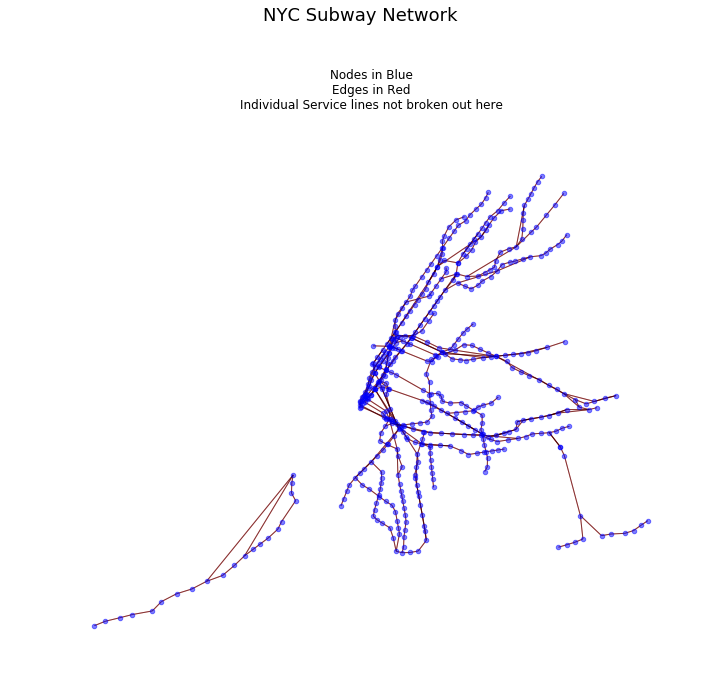

In [140]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines not broken out here
""", fontsize=12)



nx.draw_networkx_edges(G1, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G1, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )


In [141]:
nx.write_graphml(G1, "Subway_G1.graphml")

Let's verify G1 is valid when restored from file.

In [142]:
G1_test = nx.read_graphml("Subway_G1.graphml")

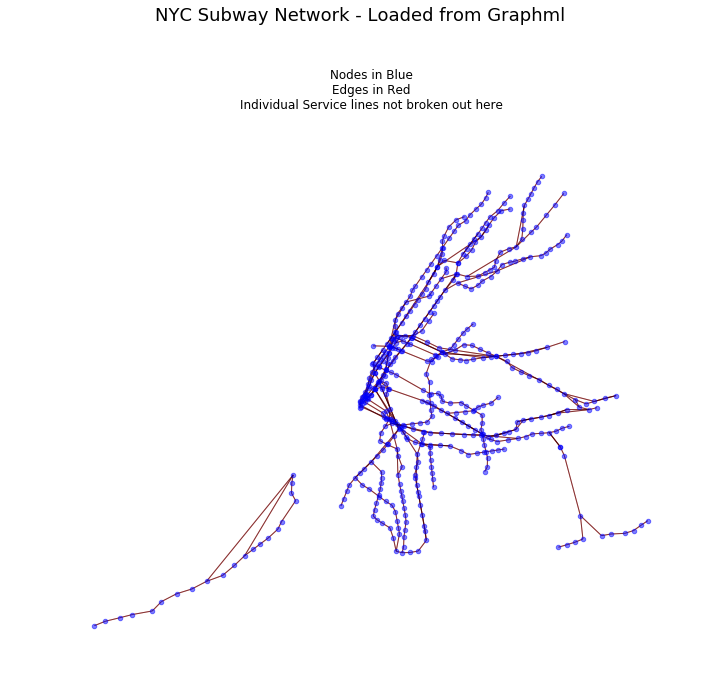

In [143]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Loaded from Graphml", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines not broken out here
""", fontsize=12)



nx.draw_networkx_edges(G1_test, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G1_test, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )

If the above graph looks like the NYC subway, the graph was correctly saved to graphml file.

### Adding a Multigraph with Routes

We save a multigraph $G2$ in which the edges are assigned route attributes.

In [144]:
G2 = nx.MultiGraph()


for r, d in nodes_used.iterrows():
    G2.add_node(d["stop_id"], stop_name = d["stop_name"] , lat = d["stop_lat"] , lon = d["stop_lon"])

    
for r, d in no_dups_route_edges.iterrows():
    G2.add_edge(d['parent_a'], d['parent_b'], route_id = d['route_id'])

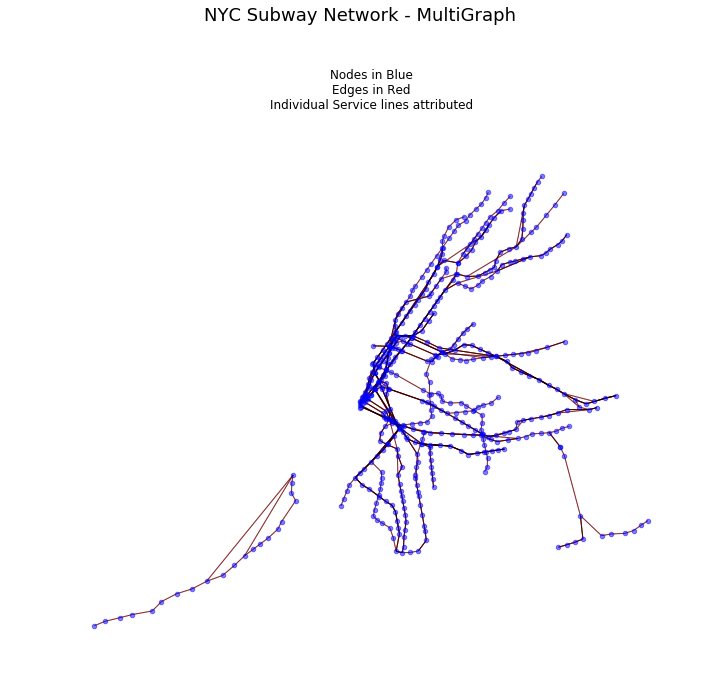

In [145]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - MultiGraph", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines attributed
""", fontsize=12)



nx.draw_networkx_edges(G2, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G2, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )

In [146]:
nx.write_graphml(G2, "Subway_G2.graphml")

In [147]:
nodes_used[ nodes_used['stop_id'] == 'H04' ]

,stop_id,stop_name,stop_lat,stop_lon
350,H04,Broad Channel,40.608382,-73.815925


In [148]:
no_dups_res_edges[ 
                 (no_dups_res_edges["parent_a"] == '127') | ( no_dups_res_edges["parent_b"] == "127") 
                 ]

,parent_a,parent_b
90171,126,127
100402,127,128
100976,123,127


## Step 4 Linking Stations Together

The next step is to build a graph with enriched data to which we referred above as $G3$.  

### Defining Nodes

To build this graph we have to define the equivalence classes
of stations where two parent nodes $a$ and $b$ of graph $G1$ are considered equivalent $a \sim b$ iff $a$ can reach $b$ by walking through passageways after paying toll at $a$.  We will call an equivalent class of such parent nodes a **linked station**.

Most subway stations are define singleton equivalence classes.  But a few important stations are highly linked.  These typically occur in Manhattan where multiple train lines intersect.   At the linked stations, traffic is typically higher as riders often transfer between lines.  The top linked stations are:

* `Times Square-42 St` where 12 lines meet.  N, Q, R, W, S, 1, 2, 3, 7, A, C, E
* `Chambers Street, WTC, Park Place, Cortlandt` where 7 lines meet.  A, C, E, 2, 3, R, W
* `Fulton St` in Manhattan where 8 lines meet.  A, C, J, Z, 2, 3, 4, 5
* `Canal St` in Manhattan where 7 lines meet.  J, N, Q, R, W, Z, 6.

However, we define three nodes attributes for linked stations:

* `borough`  - each linked station has a well-defined borough because no parent nodes in each equivalence class always belong to one borough.
* `ridership` - the total number of riders is reported based on turnstile entrances with the entire linked station.

* no loops - no stops within a linked station are stops along the same route.  Otherwise, you would be able to both walk and ride between two stops within the subway system.

* `name` the linked station node identifier is ambiguous unless the equivalence class is a singleton.  
     +  For a singleton class, we define the linked station identifier to be the `stop_id` and the name to be the `stop_name`.
     +  For a linked station with multiple parent stations, we use the string `LINK_<xxx>` where <xxx> denotes the `stop_id` of the first station lexicographically.   Example:  `LINK_127` for the linked station at Times Square-42 Street composed of `127`, `725`, `902` , `A27`, `R16`.  We will use the stop name of the first stop in this eqivalence class:  `Times Sq-42 St`.
    
### Edges

We define an edge $e$ to exist in $G3$ between two linked stations $A$ and $B$ if there exist two parent stations $a$ , $b$ belonging to $A$ and $B$ respectively where $a$ is directly connected to $b$ as consecutive stops on some train route.  
    
It is easy to see that a path in $G3$ allows a rider to get from subway stop to another in New York City in a connected path with at most one transfer at each non-singleton linked station.
  
The code below implements $G3$ according to the description above.
    

Since the ridership data does not map to `stop_id` in the GTFS specification, we mapped each linked station manually to the GTFS parent stops by comparing the station names.  Unfortunately, GTFS station names are not unique.  There are many cases of stations which the same names.  The ridership linked stations identify all subways lines which allows us to manually compare the map between the data files.   
In rare cases, a train route passes through a station but the ridership dataset does not mention the train route.  For example, the N train passes through the R subway at Court Street/Borough Hall.



In [149]:
subway_links_file = "Subway_Links_2020.csv"
subway_links = pd.read_csv(subway_links_file)

subway_links = subway_links[ ['stop_id', 'stop_name', 'Borough', 'Rides2019', 'Rides2020', 'Linked', 'node_link', 'stop_lat', 'stop_lon' ]]
subway_links = subway_links.set_index('stop_id')
subway_links

,stop_name,Borough,Rides2019,Rides2020,Linked,node_link,stop_lat,stop_lon
stop_id,,,,,,,,
101,Van Cortlandt Park-242 St,Bx,2189109,980836,1,101,40.889248,-73.898583
103,238 St,Bx,1204095,588199,1,103,40.884667,-73.900870
104,231 St,Bx,2919305,1289691,1,104,40.878856,-73.904834
106,Marble Hill-225 St,M,1561844,754010,1,106,40.874561,-73.909831
107,215 St,M,527505,212402,1,107,40.869444,-73.915279
...,...,...,...,...,...,...,...,...
R44,86 St,B,3434888,1538353,1,R44,40.622687,-74.028398
S01,Franklin Av,B,4999385,1849090,3,LINK_239,40.680596,-73.955827
R45,Bay Ridge-95 St,B,1743441,740055,1,R45,40.616622,-74.030876


In [150]:
subway_links[ subway_links.index.isin(['140', 'H19', 'N12' ] ) ]

,stop_name,Borough,Rides2019,Rides2020,Linked,node_link,stop_lat,stop_lon
stop_id,,,,,,,,


The `subway_links` dataframe contains a map between active parent stops except for Staten Island stations and 3 omitted stations discussed earlier.   The set difference of the nodes in $G1 \setminus G2$ is the Staten Island stations as shown below.

In [151]:
s1 = set( nodes_used["stop_id"]) # from G1
s2 = set( subway_links.index ) # from subway_links
( s1.difference(s2), s2.difference(s1))

({'S09',
  'S11',
  'S13',
  'S14',
  'S15',
  'S16',
  'S17',
  'S18',
  'S19',
  'S20',
  'S21',
  'S22',
  'S23',
  'S24',
  'S25',
  'S26',
  'S27',
  'S28',
  'S29',
  'S30',
  'S31'},
 set())

In [152]:
s1e = set( no_dups_res_edges['parent_a']).union( set( no_dups_res_edges['parent_b'] ) )

In [153]:
s2.difference(s1e)

set()

In [154]:
s1e.difference(s2)

{'S09',
 'S11',
 'S13',
 'S14',
 'S15',
 'S16',
 'S17',
 'S18',
 'S19',
 'S20',
 'S21',
 'S22',
 'S23',
 'S24',
 'S25',
 'S26',
 'S27',
 'S28',
 'S29',
 'S30',
 'S31'}

In [155]:
G3 = nx.Graph()

for r , d in subway_links.iterrows():
    link_node = d["node_link"]
    borough = d["Borough"]
    f19 = d["Rides2019"]
    f20 = d["Rides2020"]
    stop_name = d["stop_name"]
    lat = d["stop_lat"]
    lon = d["stop_lon"]
    
    delta_rides = f20 - f19
    
    if not link_node in G3.nodes():
        G3.add_node(link_node, borough = borough , 
                    rides2019 = f19, rides2020 = f20, delta_rides = delta_rides ,
                    link_name = stop_name ,
                    lat = lat, lon = lon
                   )

parent_nodes_used = subway_links.index
        

In [156]:
for r, ex in no_dups_res_edges.iterrows():
    
    if ex['parent_b'] in parent_nodes_used and ex['parent_a'] in parent_nodes_used:
        node_link1 =  subway_links.loc[ ex['parent_a'] , 'node_link' ]
        node_link2 =  subway_links.loc[ ex['parent_b'] , 'node_link' ]
        G3.add_edge( node_link1, node_link2 )


We see below that the linked subway graph has 420 stations and 541 edges.

In [157]:
(G3.number_of_nodes(), G3.number_of_edges())

(420, 541)

We plot the linked subway graph using the coordinates of first station of each linked node to represent the entire equivalence class of stops.

In [158]:
pos = {}
for n in G3.nodes():
     pos.update( { n :( G3.node[n]['lon'], G3.node[n]['lat'] ) } )

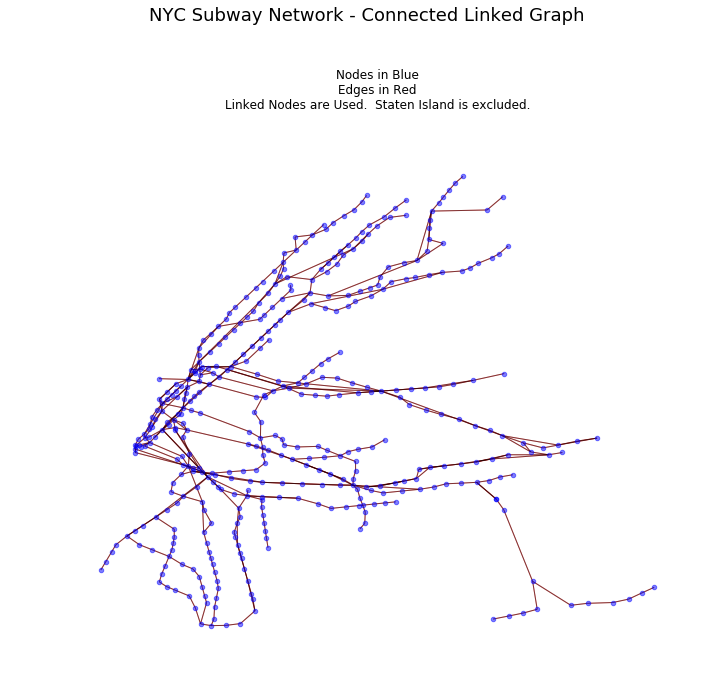

In [159]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Connected Linked Graph", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Linked Nodes are Used.  Staten Island is excluded.
""", fontsize=12)

nx.draw_networkx_edges(G3, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G3, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )


In [160]:
nx.number_connected_components(G3)

1

Now we write the linked graph to a graphml file for subsequent use.

In [161]:
nx.write_graphml(G3, "Subway_G3.graphml")

# Step X: PST Work
This will be my section for assessing the income by category given the different centrality metrics

$G3$ has 420 nodes and 541 edges

In [162]:
(G3.number_of_nodes(), G3.number_of_edges())

(420, 541)

In [163]:
# Confirm connected
nx.is_connected(G3)

True

In [164]:
# Output the connected components of G1 sorted by length (descending)
components = [c for c in sorted(nx.connected_components(G3), key=len, reverse=True)]
len(components)
[len(c) for c in components]

[420]

In [165]:
# Diameter result is 36
nx.diameter(G3)

36

In [166]:
# Ouput the average shortest path length of the largest component of G1
nx.average_shortest_path_length(G3)

11.316138197522445

Ouput the density of G1 largest comp as percentage

Less than 1% density

In [167]:
(100 * nx.density(G3))

0.6148425957495169

Draw out of the box graph of G3

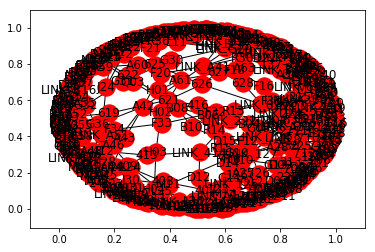

In [168]:
nx.draw_networkx(G3)

Minimum and Maximum degree counts
- Minimum: 1
- Maximum: 12

In [169]:
# From textbook; compute degree
deg = nx.degree(G3)

(min(deg.values()), max(deg.values()))

(1, 12)

12 nodes/stations with 7 or greater neighors

In [170]:
# fixed syntax from https://stackoverflow.com/questions/15712210/python-3-2-lambda-syntax-error
def sorted_map(map):
    ms = sorted(map.items(), key=lambda kv: (-kv[1],kv[0]))
    return ms

ds=sorted_map(deg)

In [171]:
ds[0:12]

[('LINK_127', 12),
 ('LINK_635', 10),
 ('LINK_235', 9),
 ('LINK_A51', 9),
 ('LINK_132', 8),
 ('LINK_312', 8),
 ('LINK_125', 7),
 ('LINK_239', 7),
 ('LINK_326', 7),
 ('LINK_629', 7),
 ('LINK_710', 7),
 ('LINK_A41', 7)]

Plot a histogram of the distribution of degree count

As expected, 2 is the highest value indicating most stations are connected to other stations

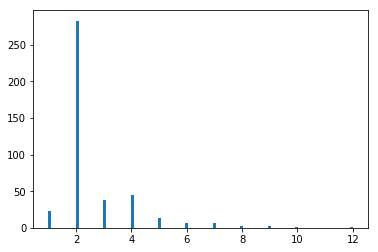

In [172]:
h = plt.hist(deg.values(), 100)

In [173]:
degrees = pd.DataFrame.from_dict(deg, orient='index')
degrees.columns = ['num_deg']

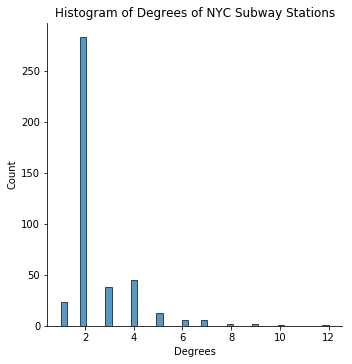

In [174]:
sns.displot(degrees, x='num_deg').set(title='Histogram of Degrees of NYC Subway Stations', xlabel='Degrees', ylabel='Count')


Calculate closeness centrality

In [175]:
c = nx.closeness_centrality(G3)
cs = sorted_map(c)
cs[:10]

[('LINK_635', 0.1465034965034965),
 ('LINK_326', 0.1450831024930748),
 ('LINK_312', 0.14403575111722242),
 ('LINK_629', 0.13742210560839618),
 ('R30', 0.13603896103896104),
 ('LINK_640', 0.13599480688088283),
 ('LINK_235', 0.13595068137573005),
 ('LINK_D17', 0.13559870550161812),
 ('LINK_127', 0.13485677502413904),
 ('LINK_637', 0.13326972010178118)]

Calculate betweenness centrality

In [176]:
b = nx.betweenness_centrality(G3)
bs = sorted_map(b)
bs[:10]

[('LINK_635', 0.4334741890627597),
 ('LINK_326', 0.3857979201315101),
 ('LINK_312', 0.37255996745806985),
 ('LINK_629', 0.36839568187372),
 ('LINK_235', 0.3059383424569957),
 ('621', 0.23030796548627794),
 ('626', 0.22483469237074893),
 ('LINK_A41', 0.2195053843972644),
 ('LINK_127', 0.21790905591553306),
 ('R30', 0.18654980762124448)]

Calculate eigenvector centrality

In [177]:
e = nx.eigenvector_centrality(G3)
es = sorted_map(e)
es[:10]

[('LINK_127', 0.43604979060839966),
 ('LINK_635', 0.2974075081781279),
 ('LINK_326', 0.2829328512939964),
 ('LINK_D17', 0.2781980316572335),
 ('LINK_724', 0.23120278221445803),
 ('LINK_125', 0.2181717350547522),
 ('LINK_132', 0.20901861286228313),
 ('LINK_A32', 0.16901420022529604),
 ('A25', 0.1630322523299623),
 ('LINK_312', 0.1582268943776909)]

Calculate PageRank

In [178]:
# PageRank
pr = nx.pagerank(G3)
prs = sorted_map(pr)
prs[:10]

[('LINK_127', 0.007809378199473141),
 ('LINK_A51', 0.006782768321871246),
 ('LINK_635', 0.006705839962997313),
 ('LINK_235', 0.006290956175581545),
 ('LINK_239', 0.005739019908167444),
 ('LINK_710', 0.0056500792972666025),
 ('LINK_132', 0.005493811352966499),
 ('LINK_312', 0.005349697388006053),
 ('LINK_A41', 0.005022118341044322),
 ('LINK_629', 0.004904200222617429)]

## What do I want to do?
- Given one of the income categories, what are the centrality measures?
    - Apply above at the borough level
    - Is there an observable relationship between income and centrality
- Something about correlation
- plot of centrality to income (no bucket)
- plot of income to measured distance from node with greatest centrality

In [179]:
# Figure out the node names from G3 compared to the stop_ids, so I can look up median income

In [180]:
# https://stackoverflow.com/questions/35046087/make-networkx-node-attributes-into-pandas-dataframe-columns
df_stations = pd.DataFrame.from_dict(dict(G3.nodes(data=True)), orient='index')
df_stations = df_stations.rename_axis('node_link').reset_index()

In [181]:
df_stations.head(5)

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon
0,101,Bx,2189109,980836,-1208273,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,Bx,1204095,588199,-615896,238 St,40.884667,-73.900870
2,104,Bx,2919305,1289691,-1629614,231 St,40.878856,-73.904834
3,106,M,1561844,754010,-807834,Marble Hill-225 St,40.874561,-73.909831
4,107,M,527505,212402,-315103,215 St,40.869444,-73.915279


In [182]:
# I want to load the geojson with the household income data
# https://stackoverflow.com/questions/57727739/how-to-determine-if-a-point-is-inside-a-polygon-using-geojson-and-shapely
# Note to Alex need to install shapely

import json
from shapely.geometry import shape, GeometryCollection, Point

# Open the geojson file and load into notebook
with open('acs2019_5yr_B19013_14000US36047053700/acs2019_5yr_B19013_14000US36047053700.geojson', 'r') as file:
    nyc_tract_data = json.load(file)
        
# Order: Longitude, latitude
# For a given long, lat pair in NYC, return the household median income 
def getHouseholdMedianIncomeInNycByPoint(point):
    income = -1.0
    for feature in nyc_tract_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            # Entire NYC in geojson, make sure to ignore
            if feature['properties']['name'] != "New York, NY":
                income = feature['properties']['B19013001']
    if pd.isna(income):
        income = -1.0
    return income

# Order: Longitude, latitude
# For a given long, lat pair in NYC, return the household median income and borough one-letter abbr
def getHouseholdMedianIncomeAndBoroughInNycByPoint(point):
    income = -1.0
    borough = "NONE"
    for feature in nyc_tract_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            # Entire NYC in geojson, make sure to ignore
            if feature['properties']['name'] != "New York, NY":
                income = feature['properties']['B19013001']
                #print(income)
                name = feature['properties']['name']
    
    if pd.isna(income):
        income = -1.0
    
    # Logic to translate tract name to borough
    # one-letter abbreviation: 
    # K for Brooklyn; 
    # M for Manhattan; 
    # Q for Queens; 
    # R for Staten Island, Richmond county; 
    # X for the Bronx
    if "Queens" in name:
        borough = "Q"
    elif "Bronx" in name:
        borough = "X"
    elif "Kings" in name:
        borough = "K"
    elif "Richmond" in name:
        borough = "R"
    elif "New York" in name and "Census Tract" in name:
        borough = "M"
    else:
        borough = "ERROR"
    
    return income, borough

# For a row from the dataset get the household median income by using the long, lat
def getHouseholdMedianIncomeInNycByRow(row):
    return getHouseholdMedianIncomeInNycByPoint(Point(row['lon'], row['lat']))

# For a row from the dataset get the household median income, income category by using the long, lat
def getIncomeAndIncomeCategoryInNycByRow(row):
    income = getHouseholdMedianIncomeInNycByPoint(Point(row['lon'], row['lat']))

    if income < 0.0:
        if row['borough'] == 'B':
            income = 68080.0
        elif row['borough'] == 'Q':
            income = 74960.0
        elif row['borough'] == 'M':
            income = 95250.0
        elif row['borough'] == 'Bx':
            income = 42140.0
    
    # Bucket income
    #Low: less than or equal to $36,000
    #Medium: Between $36,001 and $78,000
    #High: Between $78,001 and $150,000
    #Very high: greater than $150,000
    incomeCategory = "NONE"
    if income < 0.0:
        incomeCategory = "NA"
    elif income <= 36000:
        incomeCategory = "LOW"
    elif income <= 78000:
        incomeCategory = "MED"
    elif income <= 150000:
        incomeCategory = "HIGH"
    elif income > 150000:
        incomeCategory = "VHIGH"
    else:
        incomeCategory = "ERROR"
        
    return income, incomeCategory

Test case with my personal long, lat.
Returns the correct median income.

In [183]:
# 40.67282497091544, -73.96099311265702 :: 790 Classon
getHouseholdMedianIncomeInNycByPoint(Point(-73.96099311265702, 40.67282497091544))

86534.0

In [184]:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o

res = df_stations.apply(lambda row: getIncomeAndIncomeCategoryInNycByRow(row), axis=1)
df = pd.DataFrame(res.tolist())
df.columns=['hh_med_income', 'income_category']
df_stations_with_income = pd.concat([df_stations, df], axis=1)
df_stations_with_income

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon,hh_med_income,income_category
0,101,Bx,2189109,980836,-1208273,Van Cortlandt Park-242 St,40.889248,-73.898583,58467.0,MED
1,103,Bx,1204095,588199,-615896,238 St,40.884667,-73.900870,26887.0,LOW
2,104,Bx,2919305,1289691,-1629614,231 St,40.878856,-73.904834,26887.0,LOW
3,106,M,1561844,754010,-807834,Marble Hill-225 St,40.874561,-73.909831,32295.0,LOW
4,107,M,527505,212402,-315103,215 St,40.869444,-73.915279,70223.0,MED
...,...,...,...,...,...,...,...,...,...,...
415,R42,B,2354120,1023374,-1330746,Bay Ridge Av,40.634967,-74.023377,56768.0,MED
416,R43,B,1674582,700333,-974249,77 St,40.629742,-74.025510,86165.0,HIGH
417,R44,B,3434888,1538353,-1896535,86 St,40.622687,-74.028398,100324.0,HIGH
418,R45,B,1743441,740055,-1003386,Bay Ridge-95 St,40.616622,-74.030876,77569.0,MED


In [185]:
df_stations_with_income.head(10)

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon,hh_med_income,income_category
0,101,Bx,2189109,980836,-1208273,Van Cortlandt Park-242 St,40.889248,-73.898583,58467.0,MED
1,103,Bx,1204095,588199,-615896,238 St,40.884667,-73.900870,26887.0,LOW
2,104,Bx,2919305,1289691,-1629614,231 St,40.878856,-73.904834,26887.0,LOW
3,106,M,1561844,754010,-807834,Marble Hill-225 St,40.874561,-73.909831,32295.0,LOW
4,107,M,527505,212402,-315103,215 St,40.869444,-73.915279,70223.0,MED
5,108,M,1853146,892067,-961079,207 St,40.864621,-73.918822,42525.0,MED
6,LINK_109,M,2079656,1055222,-1024434,Dyckman St,40.860531,-73.925536,56855.0,MED
7,110,M,2333160,453577,-1879583,191 St,40.855225,-73.929412,48245.0,MED
8,LINK_111,M,3523536,1682772,-1840764,181 St,40.849505,-73.933596,42917.0,MED
9,LINK_112,M,6156288,3265733,-2890555,168 St-Washington Hts,40.840556,-73.940133,42157.0,MED


In [186]:
# https://stackoverflow.com/questions/29794959/pandas-add-new-column-to-dataframe-from-dictionary
df_stations_with_income['degrees'] = df_stations_with_income['node_link'].map(deg)
df_stations_with_income.head(10)

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon,hh_med_income,income_category,degrees
0,101,Bx,2189109,980836,-1208273,Van Cortlandt Park-242 St,40.889248,-73.898583,58467.0,MED,1
1,103,Bx,1204095,588199,-615896,238 St,40.884667,-73.900870,26887.0,LOW,2
2,104,Bx,2919305,1289691,-1629614,231 St,40.878856,-73.904834,26887.0,LOW,2
3,106,M,1561844,754010,-807834,Marble Hill-225 St,40.874561,-73.909831,32295.0,LOW,2
4,107,M,527505,212402,-315103,215 St,40.869444,-73.915279,70223.0,MED,2
5,108,M,1853146,892067,-961079,207 St,40.864621,-73.918822,42525.0,MED,2
6,LINK_109,M,2079656,1055222,-1024434,Dyckman St,40.860531,-73.925536,56855.0,MED,4
7,110,M,2333160,453577,-1879583,191 St,40.855225,-73.929412,48245.0,MED,2
8,LINK_111,M,3523536,1682772,-1840764,181 St,40.849505,-73.933596,42917.0,MED,4
9,LINK_112,M,6156288,3265733,-2890555,168 St-Washington Hts,40.840556,-73.940133,42157.0,MED,5


In [187]:
df_stations_with_income['btwn_cent'] = df_stations_with_income['node_link'].map(b)
df_stations_with_income['clos_cent'] = df_stations_with_income['node_link'].map(c)
df_stations_with_income['eign_cent'] = df_stations_with_income['node_link'].map(e)
df_stations_with_income['page_rank'] = df_stations_with_income['node_link'].map(pr)

In [188]:
df_stations_with_income.head()

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon,hh_med_income,income_category,degrees,btwn_cent,clos_cent,eign_cent,page_rank
0,101,Bx,2189109,980836,-1208273,Van Cortlandt Park-242 St,40.889248,-73.898583,58467.0,MED,1,0.000000,0.052857,2.093829e-08,0.001517
1,103,Bx,1204095,588199,-615896,238 St,40.884667,-73.900870,26887.0,LOW,2,0.004773,0.055800,9.882683e-08,0.002728
2,104,Bx,2919305,1289691,-1629614,231 St,40.878856,-73.904834,26887.0,LOW,2,0.009524,0.059072,4.455047e-07,0.002547
3,106,M,1561844,754010,-807834,Marble Hill-225 St,40.874561,-73.909831,32295.0,LOW,2,0.014251,0.062734,2.003755e-06,0.002421
4,107,M,527505,212402,-315103,215 St,40.869444,-73.915279,70223.0,MED,2,0.018956,0.066858,9.011107e-06,0.002312


https://furmancenter.org/stateofthecity/view/citywide-and-borough-data
- 2019 median hh income
- BK: Median household income in 2019 was \$68,080
- BX: Median household income in 2019 was \$42,140
- MN: Median household income in 2019 was \$95,250
- QU: Median household income in 2019 was \$74,960
- SI: Median household income in 2019 was \$91,360

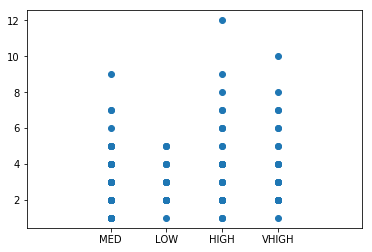

In [189]:
plt.scatter(df_stations_with_income['income_category'], df_stations_with_income['degrees'])
plt.margins(x=0.5)
plt.show()

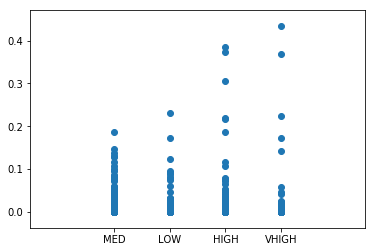

In [190]:
plt.scatter(df_stations_with_income['income_category'], df_stations_with_income['btwn_cent'])
plt.margins(x=0.5)
plt.show()

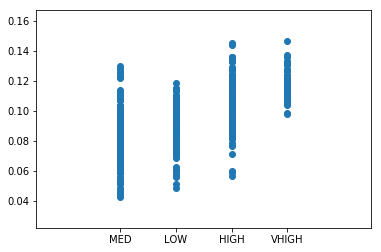

In [191]:
plt.scatter(df_stations_with_income['income_category'], df_stations_with_income['clos_cent'])
plt.margins(x=0.5)
plt.show()

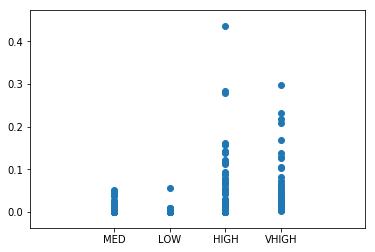

In [192]:
plt.scatter(df_stations_with_income['income_category'], df_stations_with_income['eign_cent'])
plt.margins(x=0.5)
plt.show()

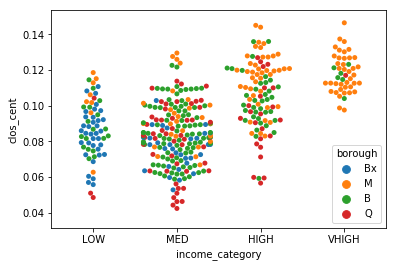

In [193]:
# https://stackoverflow.com/questions/47269695/plotting-categorical-variable-against-numeric-variable-in-matplotlib
sns.swarmplot(x='income_category', y='clos_cent', data=df_stations_with_income, hue='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'])

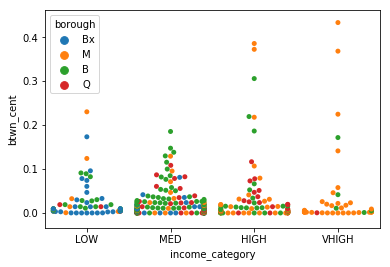

In [194]:
sns.swarmplot(x='income_category', y='btwn_cent', data=df_stations_with_income, hue='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'])

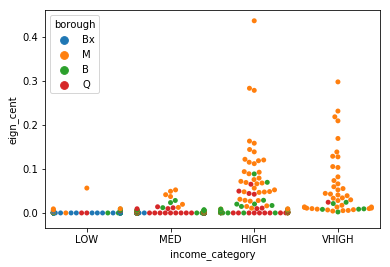

In [195]:
sns.swarmplot(x='income_category', y='eign_cent', data=df_stations_with_income, hue='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'])

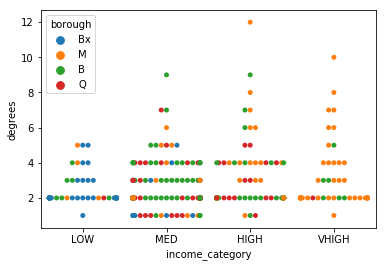

In [196]:
sns.swarmplot(x='income_category', y='degrees', data=df_stations_with_income, hue='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'])

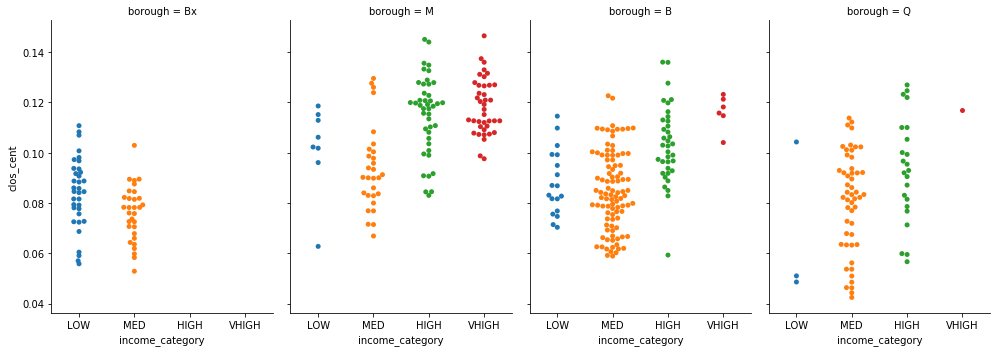

In [197]:
sns.catplot(x='income_category', y='clos_cent', data=df_stations_with_income, 
            col='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'],
            aspect=.7, kind="swarm")

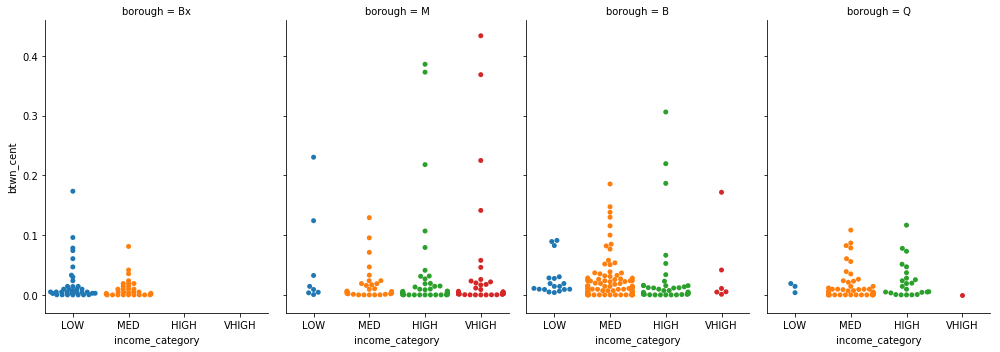

In [198]:
sns.catplot(x='income_category', y='btwn_cent', data=df_stations_with_income, 
            col='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'],
            aspect=.7, kind="swarm")

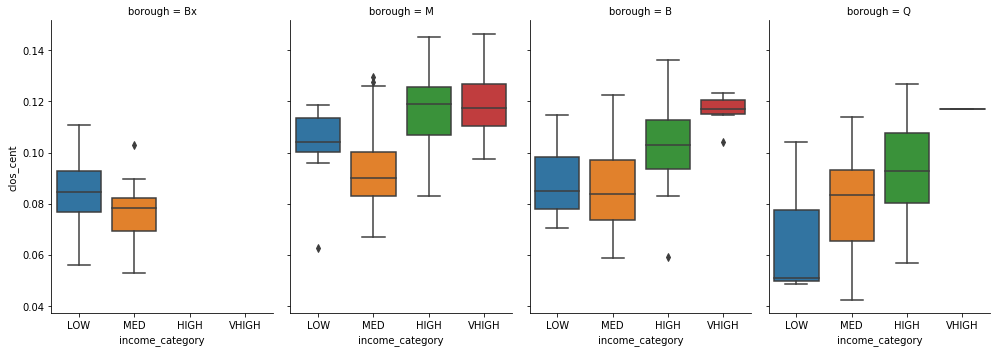

In [199]:
sns.catplot(x='income_category', y='clos_cent', data=df_stations_with_income, 
            col='borough', order=['LOW', 'MED', 'HIGH', 'VHIGH'],
            aspect=.7, kind="box")

## Distance from most popular station (aka most central node)
Times Sq-42 St

In [200]:
center_lon = df_stations_with_income[df_stations_with_income['link_name']=='Times Sq-42 St'].lon.item()
center_lat = df_stations_with_income[df_stations_with_income['link_name']=='Times Sq-42 St'].lat.item()

In [201]:
# https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
import geopy.distance
# Tell Alex to install geopy module

def calculateDistanceFromRowInMiles(row):
    return calculateDistanceFromPointInMiles(center_lat, center_lon, row['lat'], row['lon'])

def calculateDistanceFromPointInMiles(orig_lat, orig_lon, dest_lat, dest_lon):
    orig = (orig_lat, orig_lon)
    dest = (dest_lat, dest_lon)
    return (geopy.distance.distance(orig, dest).miles)

In [202]:
res = df_stations_with_income.apply(lambda row: calculateDistanceFromRowInMiles(row), axis=1)
res
df = pd.DataFrame(res.tolist())
df.columns=['dist_from_tsquare']
df_stations_with_income_ts = pd.concat([df_stations_with_income, df], axis=1)
df_stations_with_income_ts

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon,hh_med_income,income_category,degrees,btwn_cent,clos_cent,eign_cent,page_rank,dist_from_tsquare
0,101,Bx,2189109,980836,-1208273,Van Cortlandt Park-242 St,40.889248,-73.898583,58467.0,MED,1,0.000000,0.052857,2.093829e-08,0.001517,10.352099
1,103,Bx,1204095,588199,-615896,238 St,40.884667,-73.900870,26887.0,LOW,2,0.004773,0.055800,9.882683e-08,0.002728,10.015999
2,104,Bx,2919305,1289691,-1629614,231 St,40.878856,-73.904834,26887.0,LOW,2,0.009524,0.059072,4.455047e-07,0.002547,9.564470
3,106,M,1561844,754010,-807834,Marble Hill-225 St,40.874561,-73.909831,32295.0,LOW,2,0.014251,0.062734,2.003755e-06,0.002421,9.182170
4,107,M,527505,212402,-315103,215 St,40.869444,-73.915279,70223.0,MED,2,0.018956,0.066858,9.011107e-06,0.002312,8.739669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415,R42,B,2354120,1023374,-1330746,Bay Ridge Av,40.634967,-74.023377,56768.0,MED,2,0.014251,0.099101,1.352112e-03,0.002144,8.513717
416,R43,B,1674582,700333,-974249,77 St,40.629742,-74.025510,86165.0,HIGH,2,0.009524,0.090263,3.008134e-04,0.002380,8.890168
417,R44,B,3434888,1538353,-1896535,86 St,40.622687,-74.028398,100324.0,HIGH,2,0.004773,0.082839,6.678190e-05,0.002620,9.398706
418,R45,B,1743441,740055,-1003386,Bay Ridge-95 St,40.616622,-74.030876,77569.0,MED,1,0.000000,0.076516,1.415967e-05,0.001470,9.835942


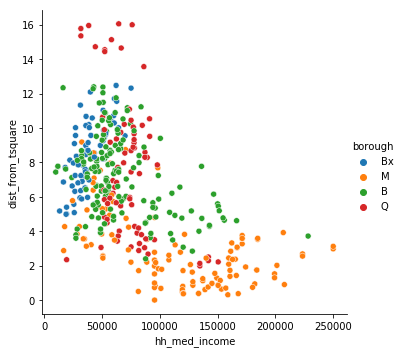

In [203]:
sns.relplot(x="hh_med_income", y="dist_from_tsquare", hue="borough", data=df_stations_with_income_ts)

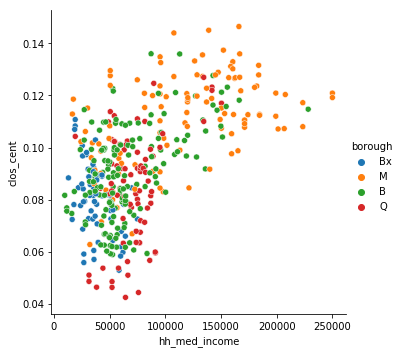

In [204]:
sns.relplot(x="hh_med_income", y="clos_cent", hue="borough", data=df_stations_with_income_ts)

Let's try Correlation

In [205]:
my_rho = np.corrcoef(df_stations_with_income['hh_med_income'], df_stations_with_income['clos_cent'])

print(my_rho)

[[1.         0.56969418]
 [0.56969418 1.        ]]


In [206]:
corr_cc = df_stations_with_income['hh_med_income'].corr(df_stations_with_income['clos_cent'])
corr_cc

0.5696941753665095

In [207]:
corr_bc = df_stations_with_income['hh_med_income'].corr(df_stations_with_income['btwn_cent'])
corr_bc

0.08633796036518014

In [208]:
corr_ec = df_stations_with_income['hh_med_income'].corr(df_stations_with_income['eign_cent'])
corr_ec

0.44655713269284875

In [209]:
corr_dg = df_stations_with_income['hh_med_income'].corr(df_stations_with_income['degrees'])
corr_dg

0.19791505102143092

In [210]:
# Output of nothing proves that the mutation of the median income by borough did work
df_stations_with_income[df_stations_with_income['hh_med_income'] < 0]

,node_link,borough,rides2019,rides2020,delta_rides,link_name,lat,lon,hh_med_income,income_category,degrees,btwn_cent,clos_cent,eign_cent,page_rank
